Found 800 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


C:\Users\Admin\AppData\Local\Temp\ipykernel_10864\3900393234.py:51: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))


Epoch 1/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 189s 4s/step - accuracy: 0.6284 - loss: 0.7009 - val_accuracy: 0.9115 - val_loss: 0.3089 - learning_rate: 1.0000e-04
Epoch 2/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.7500 - val_loss: 0.3731 - learning_rate: 1.0000e-04
Epoch 3/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 98s 4s/step - accuracy: 0.9043 - loss: 0.2845 - val_accuracy: 0.9896 - val_loss: 0.1520 - learning_rate: 1.0000e-04
Epoch 4/15

Validation accuracy reached 100% at epoch 4. Saving model...
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 327ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.1791 - learning_rate: 1.0000e-04
Epoch 5/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.9726 - loss: 0.1364 - val_accuracy: 0.9948 - val_loss: 0.1051 - learning_rate: 1.0000e-04
Epoch 6/15

Validation accuracy reached 100% at epoch 6. Saving model...
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.0000e+00 - loss: 0.00

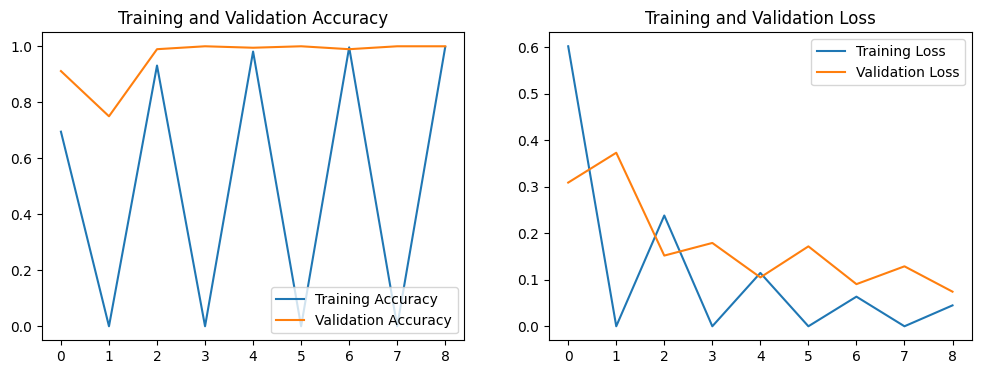

In [27]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, Callback
import os

# Set image dimensions and batch size
IMG_HEIGHT, IMG_WIDTH = 150, 150
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.2  # 20% of the data for validation

# Path to the dataset directory containing "positive" and "negative" subfolders
data_dir = r'C:\Users\Admin\Desktop\pnuemonia'

# ImageDataGenerator with validation split
datagen = ImageDataGenerator(
    rescale=1.0/255,
    validation_split=VALIDATION_SPLIT,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Training data generator
train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training'
)

# Validation data generator
validation_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation'
)

# Load the pre-trained MobileNetV2 model without the top classification layer
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# Unfreeze the last few layers of MobileNetV2
for layer in base_model.layers[-20:]:
    layer.trainable = True

# Build the model with the pre-trained base model + custom layers
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # For binary classification
])

# Compile the model
model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

# Custom callback to save model when val_accuracy == 1.0
class SaveHighAccuracyModel(Callback):
    def __init__(self, save_path):
        super(SaveHighAccuracyModel, self).__init__()
        self.save_path = save_path

    def on_epoch_end(self, epoch, logs=None):
        val_accuracy = logs.get('val_accuracy')
        if val_accuracy == 1.0:  # Save only if validation accuracy is 1
            print(f"\nValidation accuracy reached 100% at epoch {epoch + 1}. Saving model...")
            self.model.save(self.save_path)

# Define the checkpoint location (save to Desktop to avoid permission issues)
checkpoint_path = r'C:\Users\Admin\Desktop\perfect_accuracy_model.keras'

# Early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True, mode='max')

# Reduce the learning rate when validation accuracy stops improving
lr_scheduler = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, min_lr=1e-6, mode='max')

# Add the custom callback
save_high_accuracy = SaveHighAccuracyModel(save_path=checkpoint_path)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=15,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=[early_stopping, lr_scheduler, save_high_accuracy]
)

# Plot training results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()




In [23]:
import gradio as gr
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Load the trained model
model = tf.keras.models.load_model(r'C:\Users\Admin\Desktop\best_model.keras')

# Define the image preprocessing and prediction function
def predict_pneumonia(image):
    # Resize and preprocess the input image
    img = image.resize((150, 150))
    img_array = img_to_array(img) / 255.0  # Normalize the image
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Make prediction
    prediction = model.predict(img_array)[0][0]

    # Use a higher threshold for more balanced predictions
    if prediction > 0.001:
        return f"Prediction: Positive (Confidence: {prediction:.2%})"
    else:
        return f"Prediction: Negative (Confidence: {1 - prediction:.2%})"

# Define the Gradio interface
interface = gr.Interface(
    fn=predict_pneumonia,
    inputs=gr.Image(type="pil"),  # Accepts images as input in PIL format
    outputs=gr.Textbox(label="Prediction"),  # Displays the prediction as text
    title="Pneumonia Prediction",
    description="Upload a chest X-ray image to predict if it is positive or negative for pneumonia.",  # Optional example images
)

# Launch the interface
interface.launch()


* Running on local URL:  http://127.0.0.1:7868

To create a public link, set `share=True` in `launch()`.
